# Graphs

This notebook contains code to generate the graphs presented in the paper. 

In [30]:
from pref_voting.voting_methods import *
from pref_voting.utility_functions import *
from pref_voting.probabilistic_methods import * 
from tqdm.notebook import tqdm

import requests
import zipfile
import io

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


## Helper functions

In [32]:
def filter_df(df): 

    vms = df['vm'].unique()
    print("Number of keys: ", len(df) / len(vms))
    key_columns = [
        'num_cands', 
        'num_voters', 
        'num_dims', 
        'correlation', 
        'rel_dispersion', 
        'num_dims_polarized', 
        'subpopulation_std', 
        'polarization_distance', 
        'num_centrist_cands', 
        'prob_centrist_voters',
        'voter_utility', 
        'normalization']
    
    filtered_dfs = []
    for vm in vms: 
        vm_df = df[df["vm"] == vm]
        filtered_dfs.append(vm_df.drop_duplicates(subset=key_columns))

    filtered_df = pd.concat(filtered_dfs)

    print("Number of unique keys: ", len(filtered_df) / len(filtered_df['vm'].unique()))

    return filtered_df

In [33]:
def generate_graph(df_to_display, title_str, hide_xlabel=False): 

    df_to_display['vm'] = df_to_display['vm'].replace('Blacks', "Black's")

    df_to_display['vm'] = df_to_display['vm'].replace('Copeland-Global-Borda', 'Copeland-Borda')
    df_to_display['vm'] = df_to_display['vm'].replace('Copeland-Global-Minimax', 'Copeland-Minimax')
    df_to_display['vm'] = df_to_display['vm'].replace('Weak Nanson', 'Nanson')
    df_to_display['vm'] = df_to_display['vm'].replace('PluralityWRunoff PUT', 'Plurality with Runoff')
    df_to_display['vm'] = df_to_display['vm'].replace('Ranked Pairs ZT', 'Ranked Pairs')

    df_to_display['vm'] = df_to_display['vm'].replace('Borda', 'Borda*')
    df_to_display['vm'] = df_to_display['vm'].replace('Plurality', 'Plurality*')
    df_to_display['vm'] = df_to_display['vm'].replace('Approval', 'Approval*')
    df_to_display['vm'] = df_to_display['vm'].replace('Instant Runoff', 'Instant Runoff*')
    df_to_display['vm'] = df_to_display['vm'].replace('Coombs', 'Coombs*')
    df_to_display['vm'] = df_to_display['vm'].replace('Bucklin', 'Bucklin*')
    df_to_display['vm'] = df_to_display['vm'].replace('Plurality with Runoff', 'Plurality with Runoff*')

    fontsize = 16

    sns.set_style("whitegrid")

    means = df_to_display.groupby("vm")["exp_soc_util_perf"].mean().sort_values()

    norm = mcolors.Normalize(vmin=0.5, vmax=1.0)

    # Define vmin and vmax
    vmin = 0.5
    vmax = 0.95

    # Use RdYlGn for above vmin
    cmap_above = plt.cm.RdYlGn
    # Extract the exact red RGB value from RdYlGn
    red_rgb = cmap_above(0)[:3]  # Take only the RGB part, ignoring alpha

    # Create a custom colormap for below vmin
    cmap_below = mcolors.LinearSegmentedColormap.from_list(
        "black_to_exact_red", [(0, "black"), (1, red_rgb)]
    )

    # Define a combined colormap function
    def stitched_colormap(value):
        if value < vmin:
            return cmap_below(value / vmin)  # Normalize within the below range
        else:
            return cmap_above((value - vmin) / (vmax - vmin))  # Normalize within the above range

    # Create a list of colors based on the stitched colormap
    colors = [stitched_colormap(value) for value in means]

    height_constant = 0.4
    height = len(df_to_display["vm"].unique()) * height_constant
    fig, ax = plt.subplots(figsize=(15, height))

    bars = ax.barh(means.index, means, color=colors, edgecolor='gray')

    sns.despine()
    plt.ylabel("")
    if not hide_xlabel: 
        plt.xlabel("\nExpected Social Utility Performance", fontsize=fontsize)
    else: 
        plt.xlabel("", fontsize=fontsize)

    plt.xticks(np.arange(0, 1.05, 0.05), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    ax.yaxis.grid(False)
    plt.savefig(f"./graphs/expected_social_utility_performance_{title_str}.pdf", bbox_inches="tight")
    plt.show()


### Download the main CSV file 

In [34]:
# download the main csv file from google cloud storage as a zip file

chunksize = 100000
filtered_chunks = []
url = 'https://storage.googleapis.com/soc-util-perf-data/exp_soc_util_perf_data.csv.zip'
response = requests.get(url)
        
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_names = z.namelist()
            
    target_file = 'exp_soc_util_perf_data.csv'
            
    if target_file not in file_names:
        raise ValueError(f"File {target_file} not found in ZIP. Available files: {file_names}")
            
    with z.open(target_file) as csvfile:
        for chunk in pd.read_csv(csvfile, chunksize=chunksize):
            if "Unnamed: 0" in chunk.columns:
                chunk.drop("Unnamed: 0", axis=1, inplace=True)

            filtered_chunks.append(chunk)
        
df_exp_performance = pd.concat(filtered_chunks, ignore_index=True)

df_exp_performance = filter_df(df_exp_performance)


Number of keys:  167232.0
Number of unique keys:  167232.0


## Unpolarized Graph

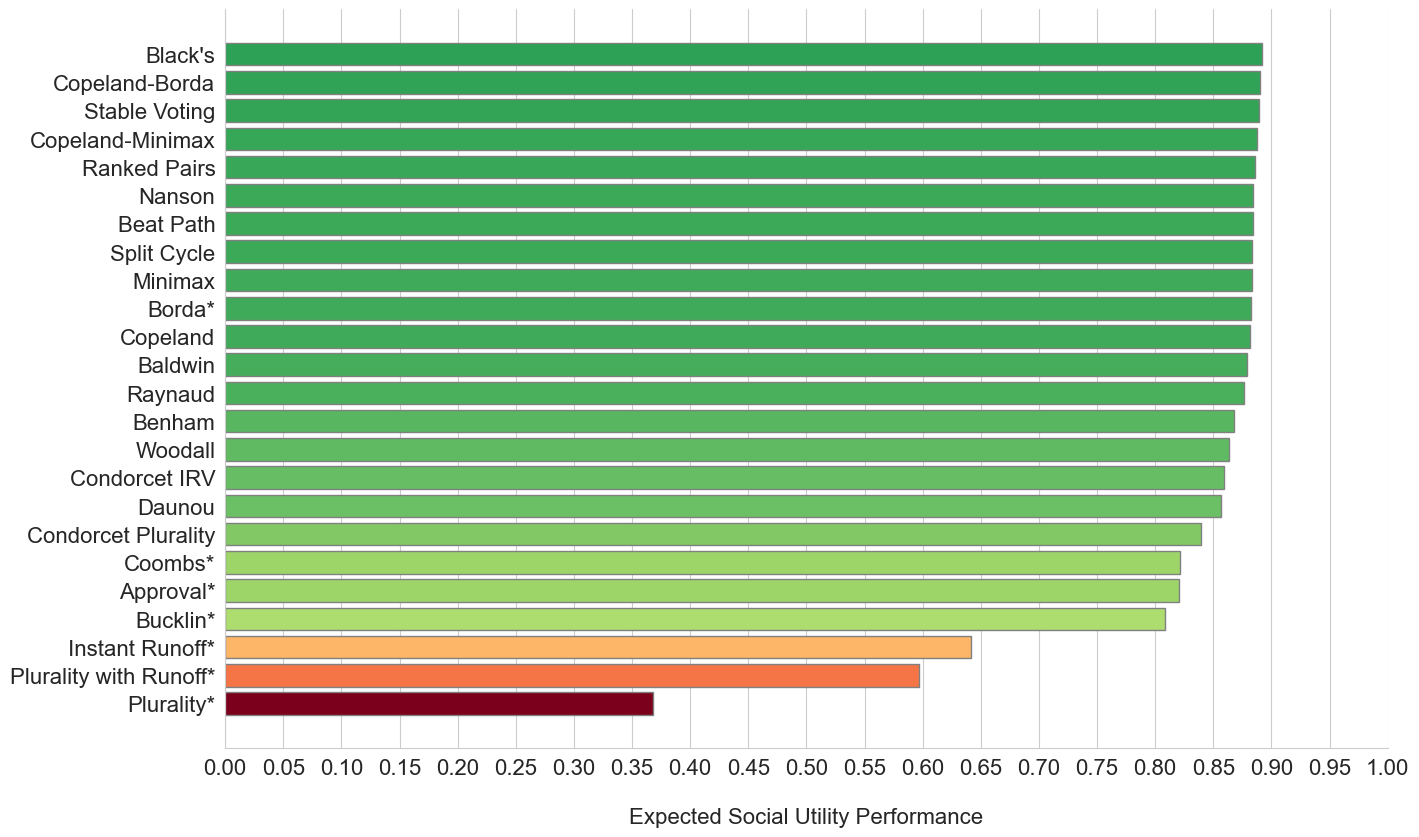

In [35]:

restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    "Baldwin", 
    "Weak Nanson",
    "Copeland",
    "Raynaud", 
    "Daunou",
    "Benham", 
    "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["num_dims_polarized"] == 0]
title_str= "unpolarized"

generate_graph(df_to_display, title_str)

## Polarized Graph

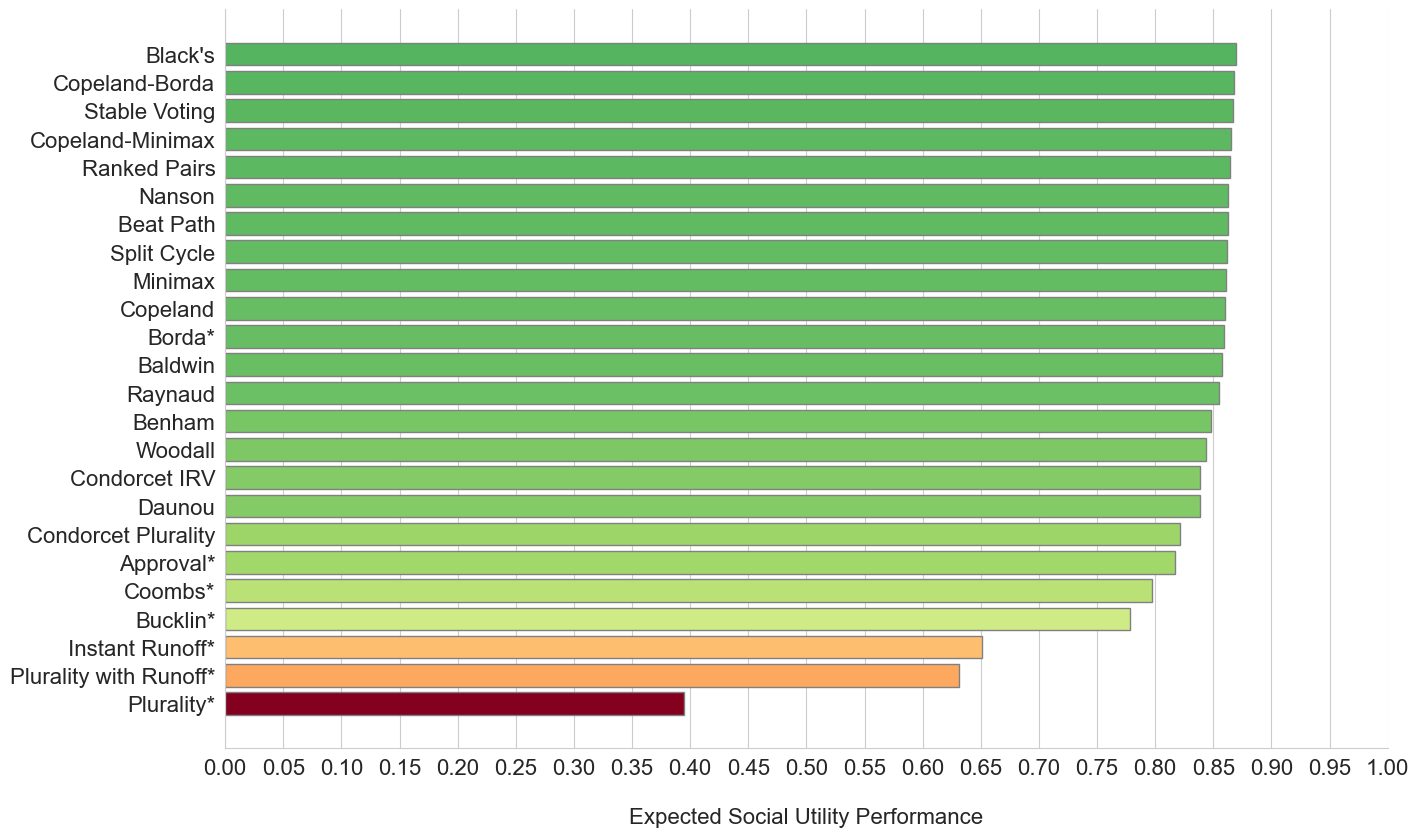

In [36]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    "Baldwin", 
    "Weak Nanson",
    "Copeland",
    "Raynaud", 
    "Daunou",
    "Benham", 
    "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["num_dims_polarized"] != 0]
title_str= "polarized"

generate_graph(df_to_display, title_str)

## 3 Candidates Graph

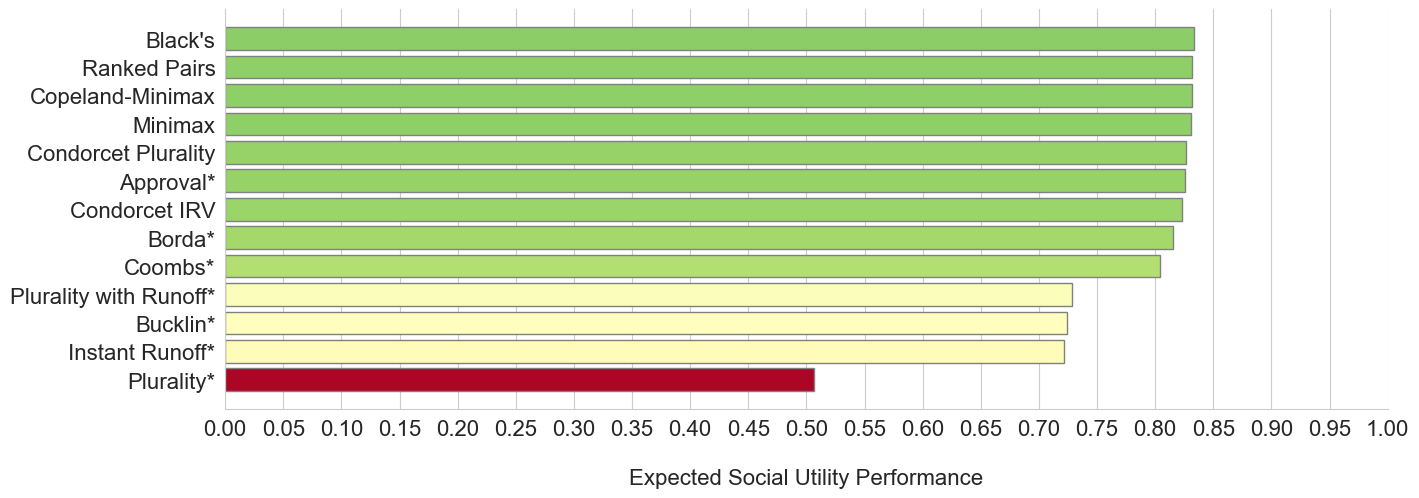

In [37]:

restricted_vms = [
    "Blacks", 
    # "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    # "Beat Path",
    # "Split Cycle",
    # "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["num_cands"] == 3]
title_str= "3_candidates"

generate_graph(df_to_display, title_str)

## 10 Candidate Graph   

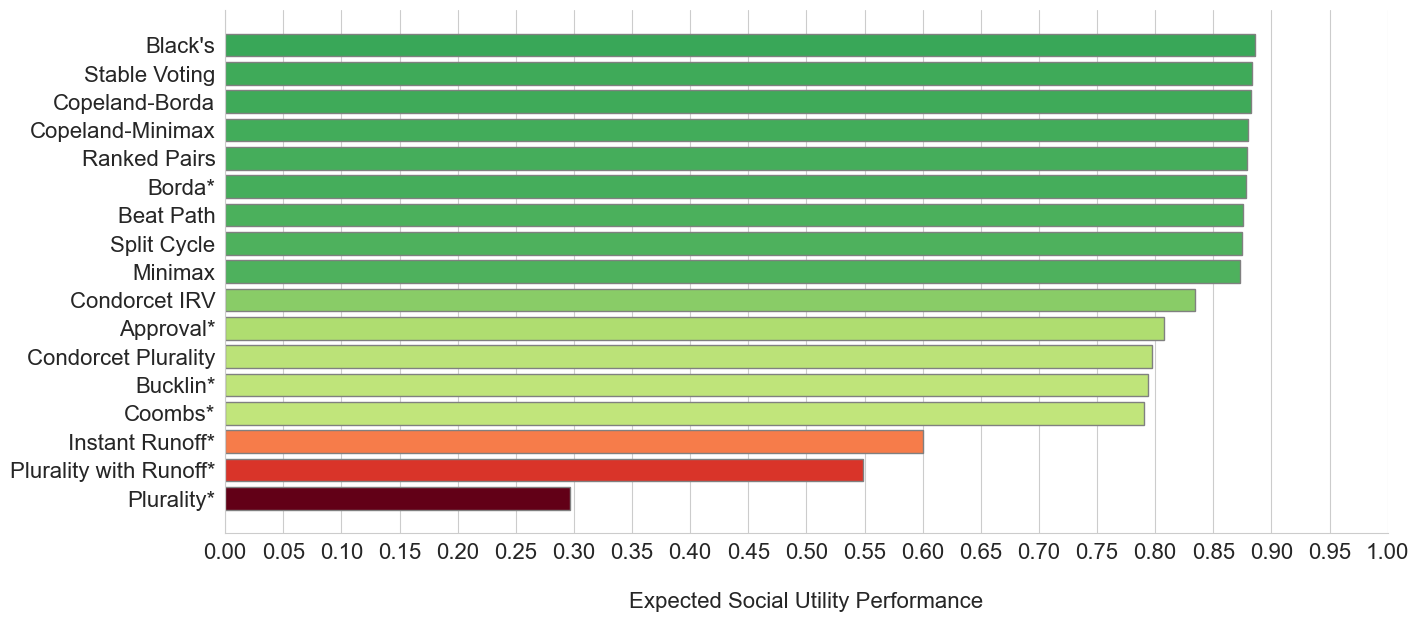

In [38]:

restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["num_cands"] == 10]
title_str= "10_candidates"


generate_graph(df_to_display, title_str)

## 11 Voters Graph

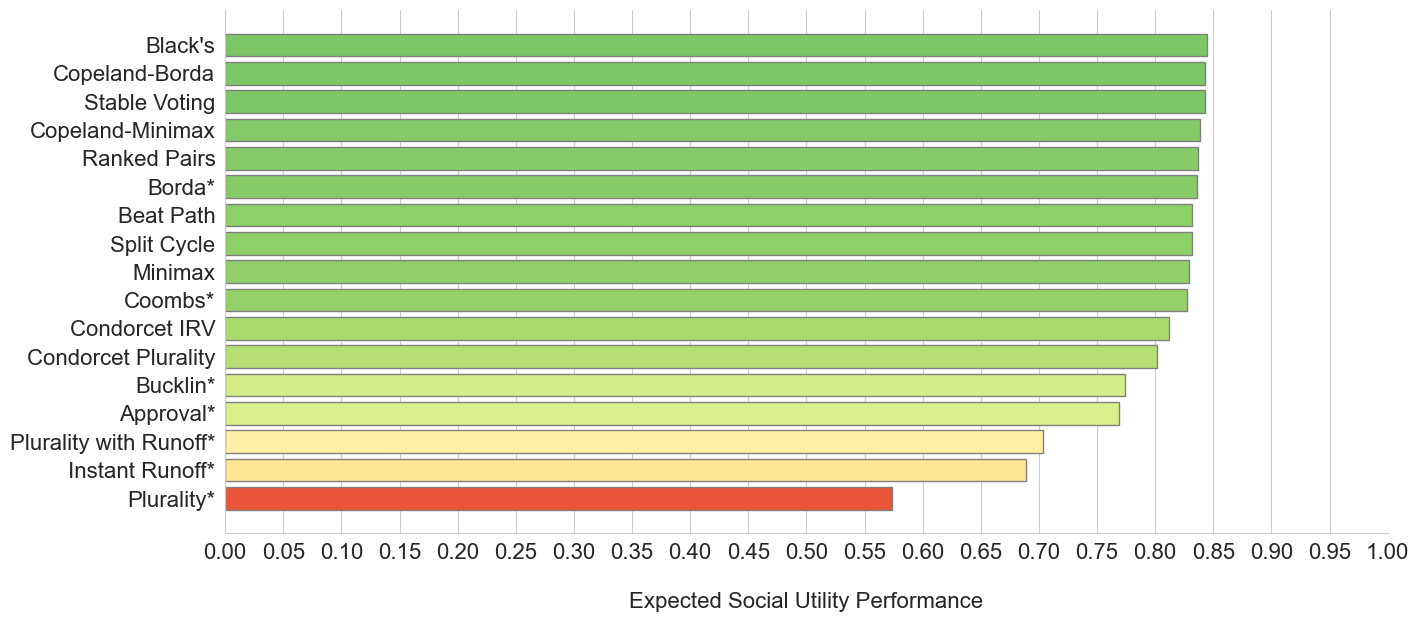

In [39]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["num_voters"] == 11]
title_str= "11_voters"


generate_graph(df_to_display, title_str)

## 1001 Voters Graph

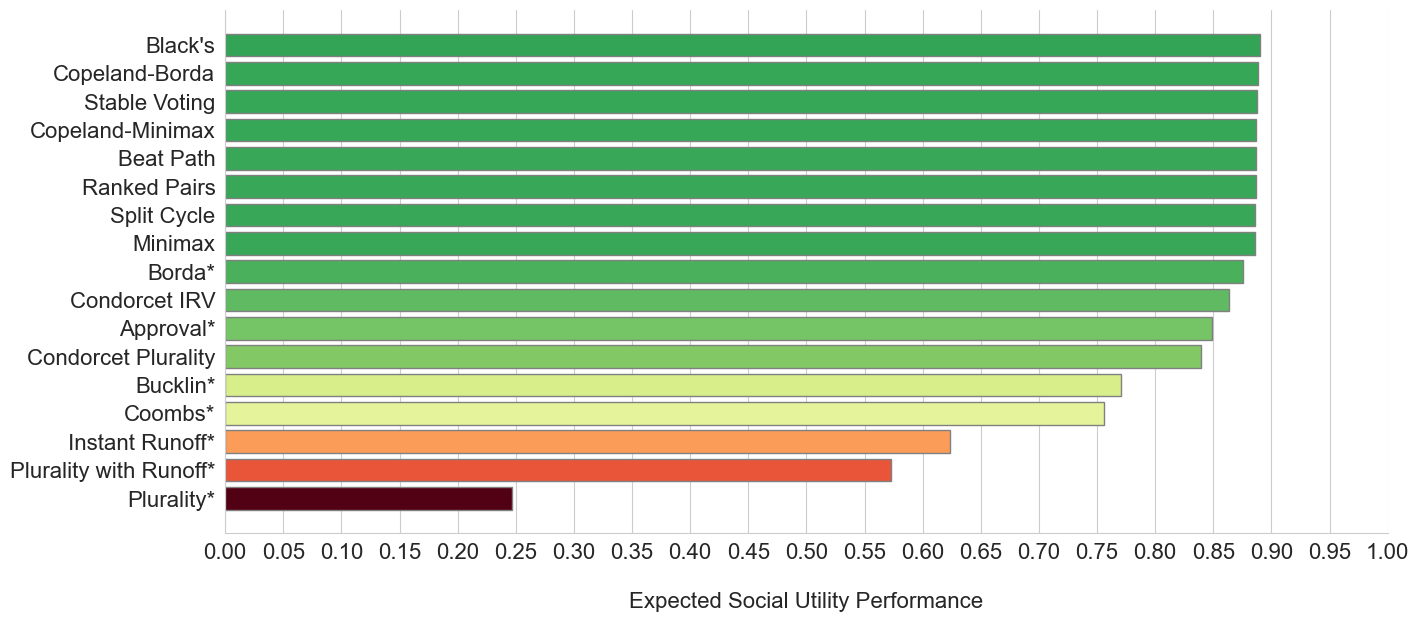

In [40]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["num_voters"] == 1001]
title_str= "1001_voters"


generate_graph(df_to_display, title_str)

## Shepsle Utility Function Graph

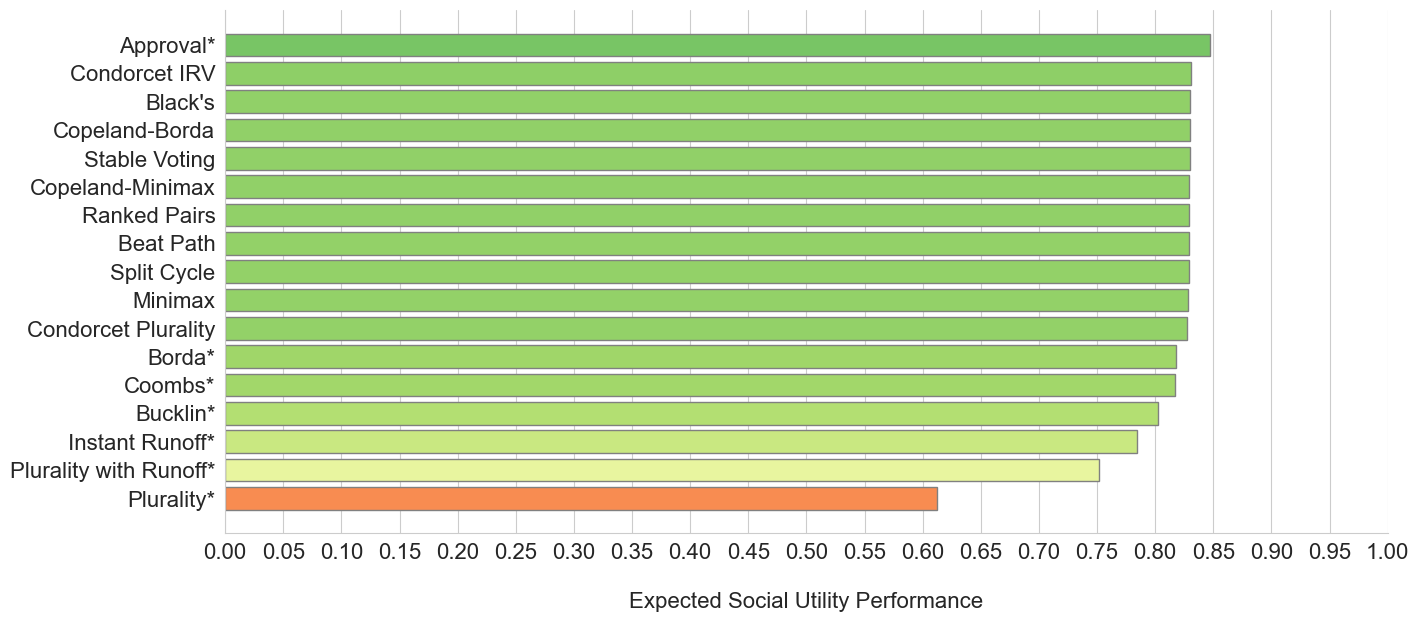

In [41]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["voter_utility"] == "Shepsle"]

title_str= "Shepsle"

generate_graph(df_to_display, title_str)

## Mixed Proximity RM Graph

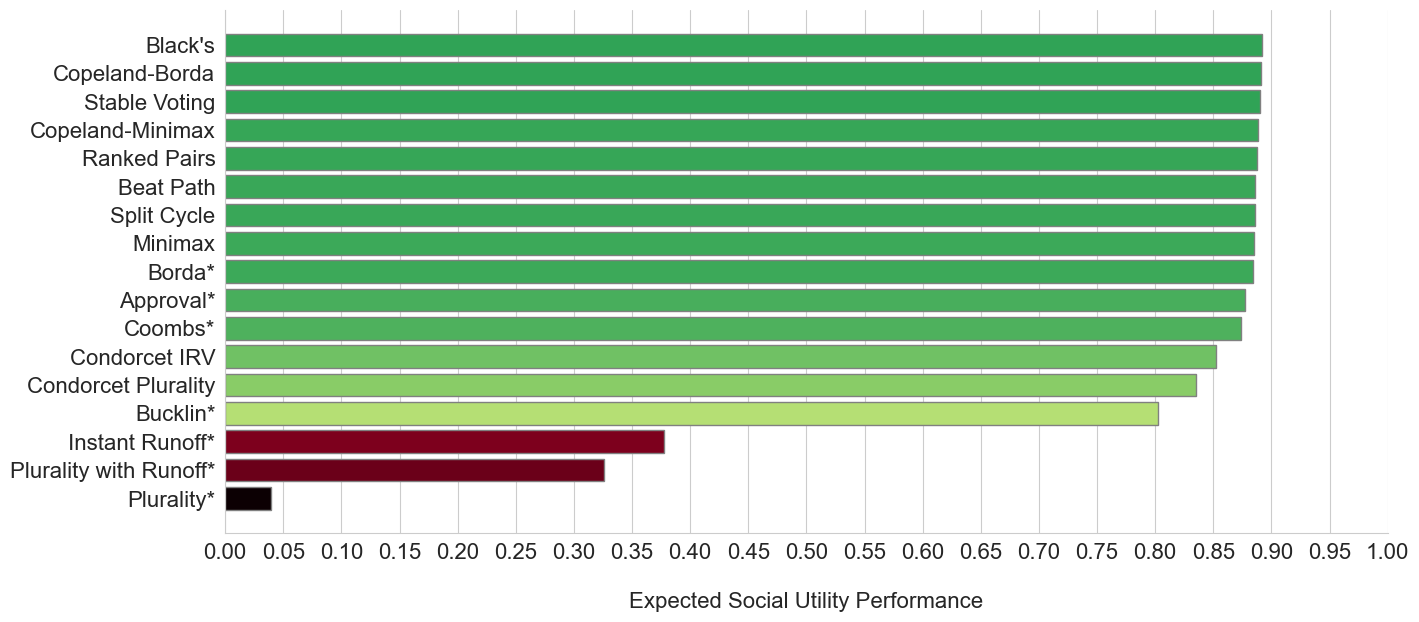

In [42]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["voter_utility"] == "Mixed Proximity-RM"]

title_str= "Mixed_Proximity-RM"

generate_graph(df_to_display, title_str)

## Normalization None Graph

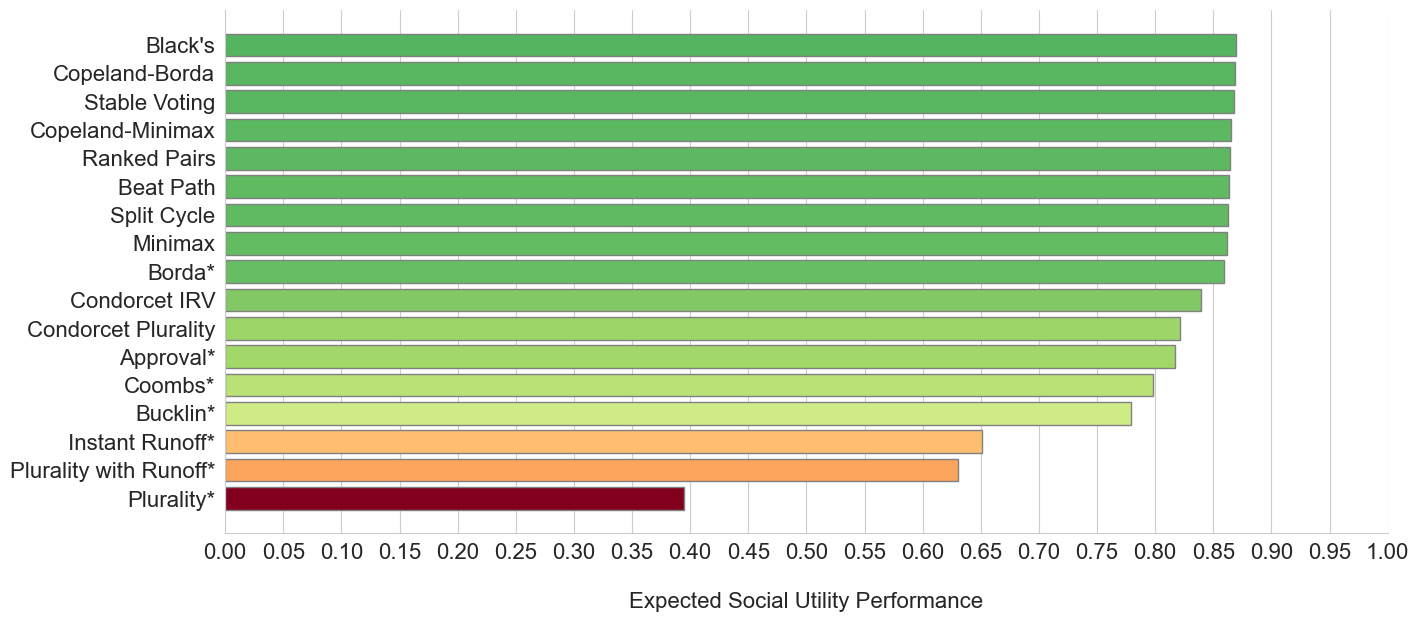

In [43]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]

title_str= "normalization_none"

generate_graph(df_to_display, title_str)

## Normalization Range Graph

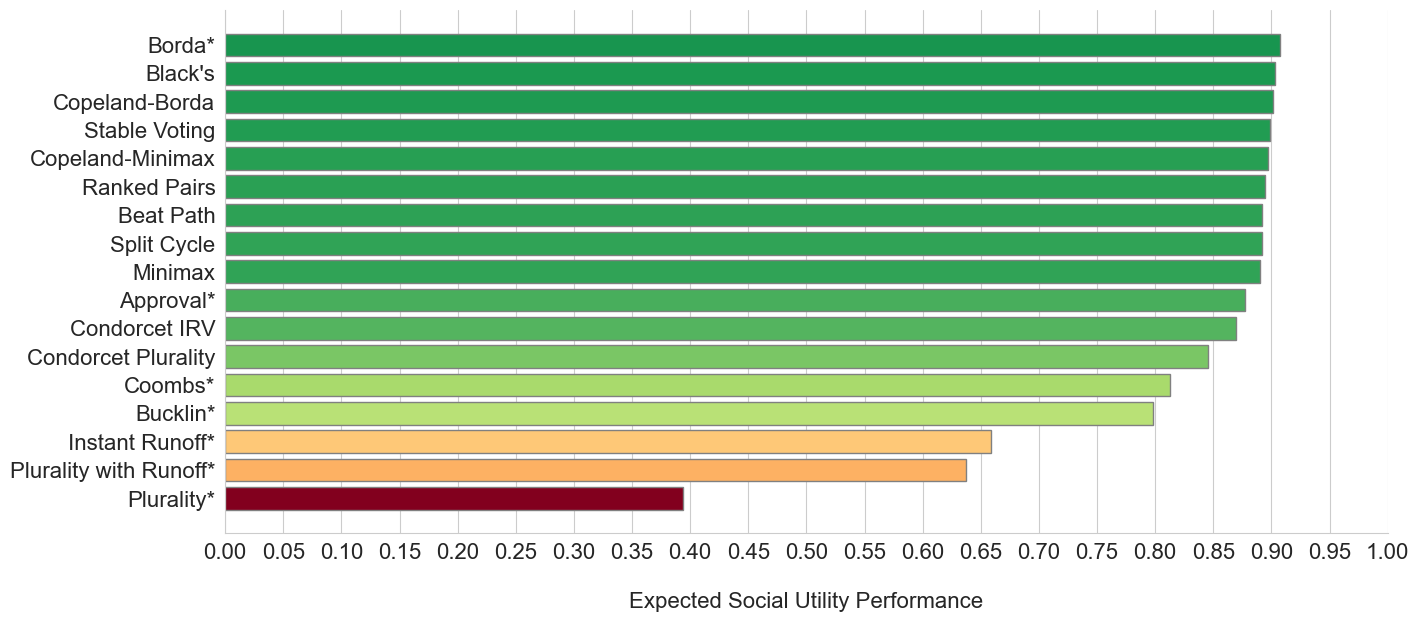

In [44]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    "PluralityWRunoff PUT",
    "Bucklin", 
    "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "range"]

title_str= "normalization_range"

generate_graph(df_to_display, title_str)

## Uncertainty Graphs

In [51]:
chunksize = 100000
filtered_chunks = []

url = 'https://storage.googleapis.com/soc-util-perf-data/exp_soc_util_perf_data_uncertainty.csv.zip'

response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # List all files in the ZIP
    file_names = z.namelist()

    csv_files = [f for f in z.namelist() if not f.startswith('__MACOSX/') and not f.startswith('._')]
    if len(csv_files) != 1:
        raise ValueError(f"Expected one file in ZIP, but found {csv_files}")
    
    with z.open(csv_files[0]) as csvfile:
        # Step 2: Read and process CSV in chunks
        for chunk in pd.read_csv(csvfile, chunksize=chunksize):

            # Drop Unnamed: 0 if it exists in this chunk
            if "Unnamed: 0" in chunk.columns:
                chunk.drop("Unnamed: 0", axis=1, inplace=True)

            filtered_chunks.append(chunk)
        
df_uncertainty =  pd.concat(filtered_chunks, ignore_index=True)



,num_cands,num_voters,num_dims,correlation,rel_dispersion,num_dims_polarized,subpopulation_std,polarization_distance,num_centrist_cands,prob_centrist_voters,...,step_trials,min_num_trials,max_std_error,num_trials,vm,exp_soc_util_perf,est_std_error,variance_soc_util_perf_values,dt,pref_voting_version
0,3,11,1,0.0,0.5,0,1.0,NaN,NaN,NaN,...,1000,10000,0.005,28000,Plurality,0.377367,0.004741,0.629203,2024-07-23 10:36:37.247693,1.13.26
1,3,11,1,0.0,0.5,0,1.0,NaN,NaN,NaN,...,1000,10000,0.005,27000,Plurality,0.347660,0.004682,0.591955,2024-08-27 19:05:12.417445,1.13.26
2,3,11,1,0.0,0.5,0,1.0,NaN,NaN,NaN,...,1000,10000,0.005,15000,Plurality,0.619923,0.004852,0.353066,2024-07-23 10:36:37.248303,1.13.26
3,3,11,1,0.0,0.5,0,1.0,NaN,NaN,NaN,...,1000,10000,0.005,10000,Plurality,0.700817,0.004984,0.248410,2024-08-27 19:05:12.417624,1.13.26
4,3,11,1,0.0,0.5,0,1.0,NaN,NaN,NaN,...,1000,10000,0.005,34000,Plurality,0.284015,0.004769,0.773123,2024-07-23 10:36:37.248062,1.13.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682491,10,1001,8,0.5,1.0,8,1.0,1.0,5.0,1.0,...,1000,10000,0.005,34000,Approval,0.711013,0.001811,0.111492,2024-09-27 09:09:04.193613,1.13.26
4682492,10,1001,8,0.5,1.0,8,1.0,1.0,5.0,1.0,...,1000,10000,0.005,10000,Approval,0.973569,0.000878,0.007710,2024-08-16 10:19:50.946834,1.13.26
4682493,10,1001,8,0.5,1.0,8,1.0,1.0,5.0,1.0,...,1000,10000,0.005,10000,Approval,0.983440,0.000578,0.003336,2024-09-27 01:46:18.617018,1.13.26
4682494,10,1001,8,0.5,1.0,8,1.0,1.0,5.0,1.0,...,1000,10000,0.005,10000,Approval,0.970860,0.000922,0.008492,2024-07-24 03:45:26.734544,1.13.26


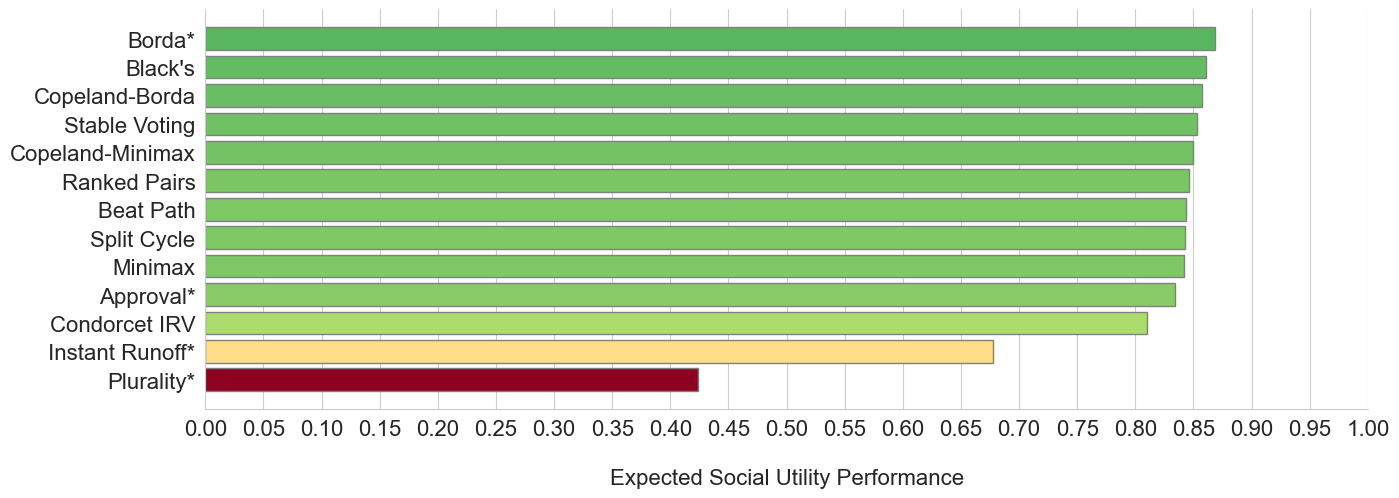

In [52]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    # "PluralityWRunoff PUT",
    # "Bucklin", 
    # "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_uncertainty[df_uncertainty["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["use_perceived_uncertainty"] == True]

title_str= "used_perceived_uncertainty_true"

generate_graph(df_to_display, title_str)

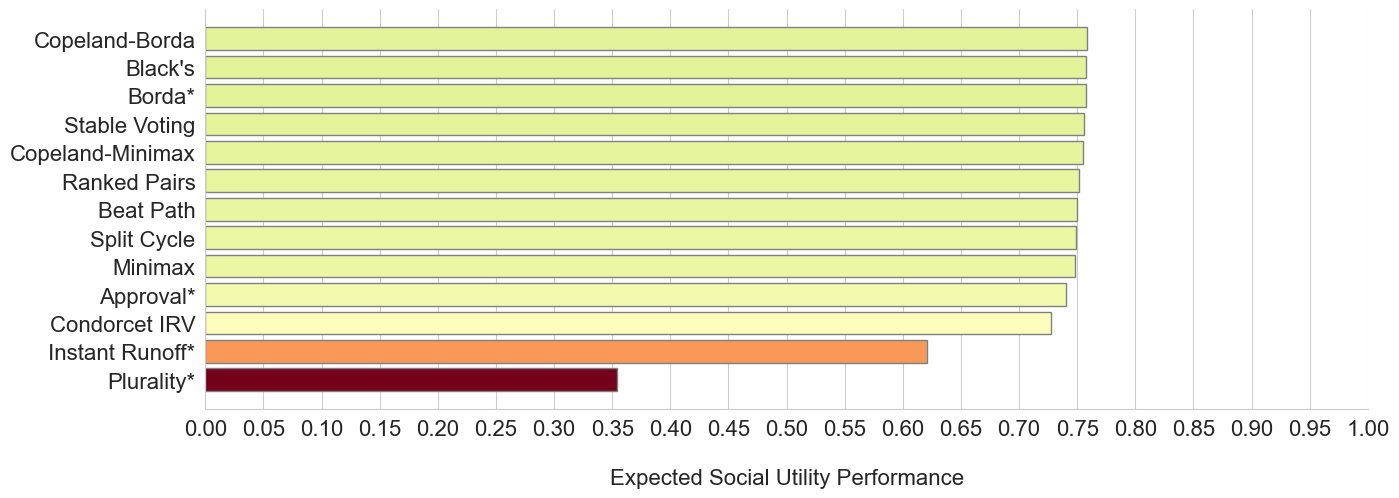

In [53]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    # "PluralityWRunoff PUT",
    # "Bucklin", 
    # "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_uncertainty[df_uncertainty["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["use_perceived_uncertainty"] == False]

title_str= "used_perceived_uncertainty_false"

generate_graph(df_to_display, title_str)

## Standard Score Graph

In [58]:
df_standard_score = pd.read_csv("./data/standard_score_keys_restricted.csv")


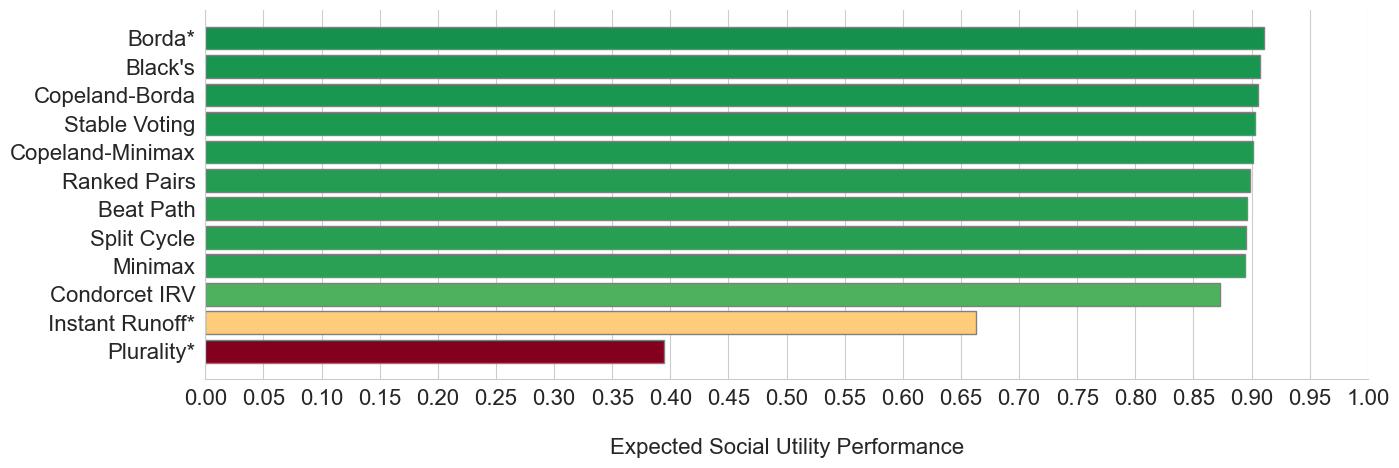

In [59]:

restricted_vms = [
    "Blacks", 
    "Copeland-Global-Borda",
    "Copeland-Global-Minimax",
    "Ranked Pairs ZT",
    "Beat Path",
    "Split Cycle",
    "Stable Voting", 
    "Minimax", 
    "Approval",
    "Condorcet IRV",
    "Condorcet Plurality",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    # "PluralityWRunoff PUT",
    # "Bucklin", 
    # "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_standard_score[df_standard_score["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "score"]

title_str= "standard_score"

generate_graph(df_to_display, title_str)

## Unbalanced Polarized Graphs

In [688]:
dfs = []

for file in glob.glob("../exp_soc_util_performance_60_40/data/*.csv"):
    dfs.append(pd.read_csv(file))

df_60_40 = pd.concat(dfs, ignore_index=True)    
print(len(df_60_40) / len(df_60_40["vm"].unique()))

dfs = []

for file in glob.glob("../exp_soc_util_performance_70_30/data/*.csv"):
    dfs.append(pd.read_csv(file))

df_70_30 = pd.concat(dfs, ignore_index=True)    
print(len(df_70_30) / len(df_70_30["vm"].unique()))


dfs = []

for file in glob.glob("../exp_soc_util_performance_80_20_eric_ultra/data/*.csv"):
    dfs.append(pd.read_csv(file))

df_80_20 = pd.concat(dfs, ignore_index=True)    
print(len(df_80_20) / len(df_80_20["vm"].unique()))
print(df_80_20["vm"].unique())


10000.0
10000.0
10000.0
['Plurality' 'Instant Runoff' 'Condorcet IRV' 'Minimax'
 'Copeland-Global-Minimax' 'Borda' 'Blacks']


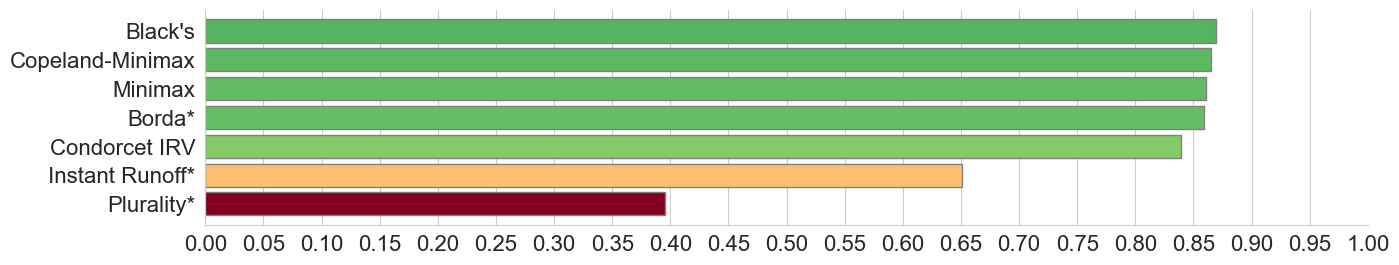

In [684]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Minimax",
    "Minimax", 
    "Condorcet IRV",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    # "PluralityWRunoff PUT",
    # "Bucklin", 
    # "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_exp_performance[df_exp_performance["vm"].isin(restricted_vms)]

df_to_display = df_to_display[df_to_display["normalization"] == "none"]
df_to_display = df_to_display[df_to_display["num_dims_polarized"] != 0]

title_str= "polarized_50_50"

generate_graph(df_to_display, title_str, hide_xlabel=True)


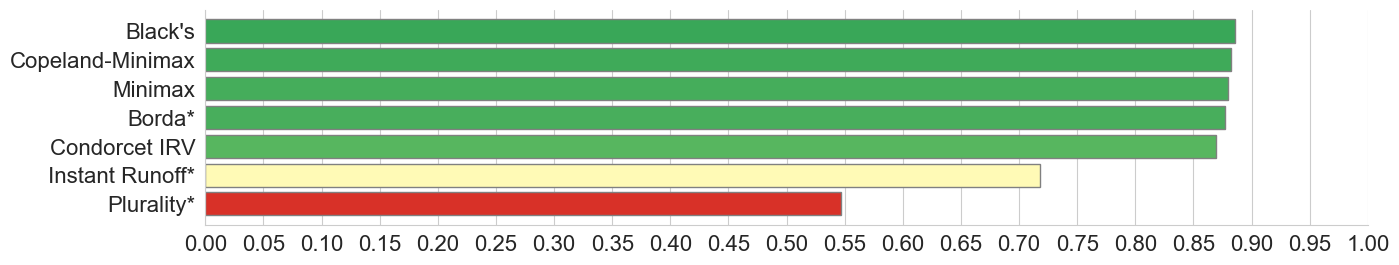

In [685]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Minimax",
    "Minimax", 
    "Condorcet IRV",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    # "PluralityWRunoff PUT",
    # "Bucklin", 
    # "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_60_40[df_60_40["vm"].isin(restricted_vms)]

#df_to_display = df_to_display[df_to_display["normalization"] == "score"]
#df_to_display = df_to_display[df_to_display["use_perceived_uncertainty"] == False]
#df_to_display = df_to_display[df_to_display["num_dims_polarized"] != 0]
#df_to_display = df_to_display[df_to_display["num_cands"] == 10]
#df_to_display = df_to_display[df_to_display["voter_utility"] == "Mixed Proximity-RM"]

title_str= "polarized_60_40"

generate_graph(df_to_display, title_str, hide_xlabel=True)


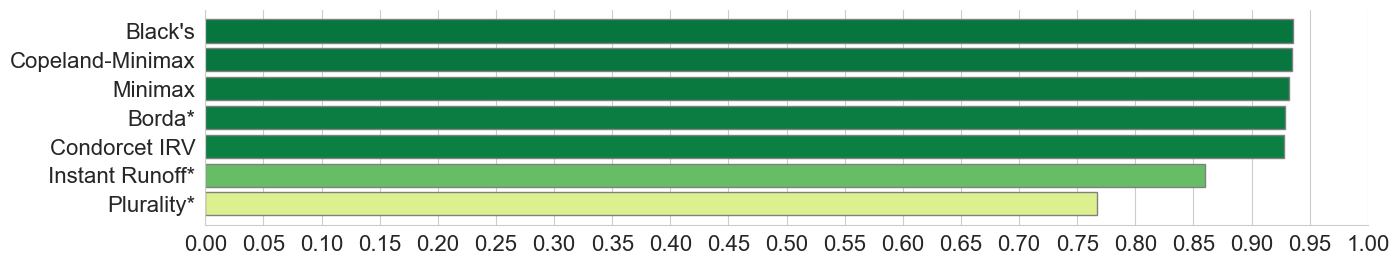

In [686]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Minimax",
    "Minimax", 
    "Condorcet IRV",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    # "PluralityWRunoff PUT",
    # "Bucklin", 
    # "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_70_30[df_70_30["vm"].isin(restricted_vms)]

#df_to_display = df_to_display[df_to_display["normalization"] == "score"]
#df_to_display = df_to_display[df_to_display["use_perceived_uncertainty"] == False]
#df_to_display = df_to_display[df_to_display["num_dims_polarized"] != 0]
#df_to_display = df_to_display[df_to_display["num_cands"] == 10]
#df_to_display = df_to_display[df_to_display["voter_utility"] == "Mixed Proximity-RM"]

title_str= "polarized_70_30"

generate_graph(df_to_display, title_str, hide_xlabel=True)


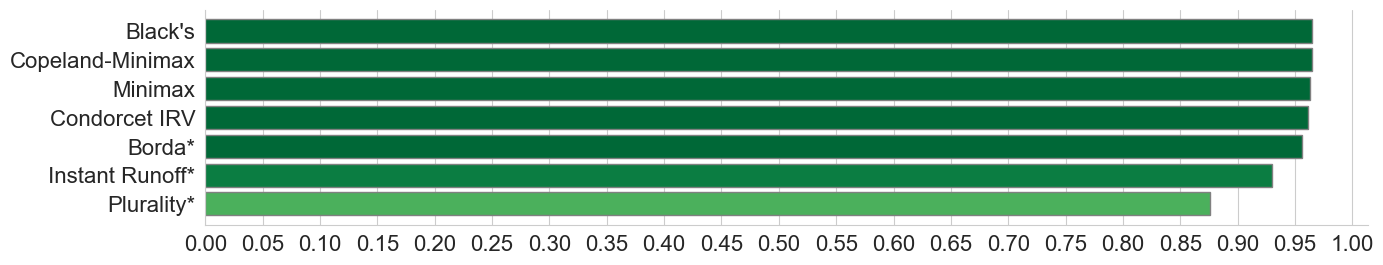

In [687]:
restricted_vms = [
    "Blacks", 
    "Copeland-Global-Minimax",
    "Minimax", 
    "Condorcet IRV",
    "Plurality", 
    "Borda", 
    "Instant Runoff",
    # "PluralityWRunoff PUT",
    # "Bucklin", 
    # "Coombs",
    ####
    # "Baldwin", 
    # "Weak Nanson",
    # "Copeland",
    # "Raynaud", 
    # "Daunou",
    # "Benham", 
    # "Woodall"
    ]

df_to_display = df_80_20[df_80_20["vm"].isin(restricted_vms)]

#df_to_display = df_to_display[df_to_display["normalization"] == "score"]
#df_to_display = df_to_display[df_to_display["use_perceived_uncertainty"] == False]
#df_to_display = df_to_display[df_to_display["num_dims_polarized"] != 0]
#df_to_display = df_to_display[df_to_display["num_cands"] == 10]
#df_to_display = df_to_display[df_to_display["voter_utility"] == "Mixed Proximity-RM"]

title_str= "polarized_80_20"

generate_graph(df_to_display, title_str, hide_xlabel=True)
